In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def read_data():
    out_name = input('Enter the output file name to export [(ex) result.txt]:')
    return out_name

In [3]:
out_name = read_data()

In [4]:
def data_generation(n, random_seed, dim=7):
    X = []
    for i in range(dim):
        np.random.seed(i+random_seed)
        if i<3:
            x = np.random.uniform(-10,10,n)
        else:
            x = np.random.normal(0,np.sqrt(10),n)
        X.append(x)
    X = np.array(X)
    X = X.reshape(-1,7,order='F')
    XB = X[:,0]*np.sqrt(np.abs(X[:,3])+1)+np.sin(X[:,2])-(np.abs(X[:,1])/np.sqrt(np.abs(X[:,4])+1))+1.5*np.abs(X[:,5])+X[:,6]
    p = 1/(1+np.exp(-XB))
    np.random.seed(random_seed)
    y = np.random.binomial(1, p, n)
    return X, y

In [5]:
n_tr = 1000
n_ts = 1000
X_tr, y_tr = data_generation(n = n_tr, random_seed = 19960314)
X_ts, y_ts = data_generation(n = n_ts, random_seed = 19940322)

In [6]:
def train_test_SVM(X_tr, y_tr, X_ts, y_ts, C, svm_type = 'linear'):
    assert svm_type in ['linear','rbf']
    SVM = SVC(kernel = svm_type, C = C)
    SVM.fit(X_tr, y_tr)
    y_ts_pred = SVM.predict(X_ts)
    test_acc = np.mean(y_ts==y_ts_pred)
    return test_acc
    

In [7]:
C_candidates = []
for i in [1,2,3,4,5]:
    for j in [1e+2, 1e+1, 1e+0, 1e-1]:
        C_candidates.append(i*j)

In [8]:
SVM_linear_result = dict()
SVM_rbf_result = dict()

for C in tqdm.tqdm(C_candidates):
    SVM_linear_result[C] = train_test_SVM(X_tr, y_tr, X_ts, y_ts, 
                                      C = C, svm_type = 'linear')
    SVM_rbf_result[C] = train_test_SVM(X_tr, y_tr, X_ts, y_ts, 
                                      C = C, svm_type = 'rbf')

100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


In [9]:
best_C_linear = max(SVM_linear_result, key=SVM_linear_result.get)
best_acc_linear = SVM_linear_result[best_C_linear]
print(best_C_linear, best_acc_linear)

10.0 0.838


In [10]:
best_C_rbf = max(SVM_rbf_result, key=SVM_rbf_result.get)
best_acc_rbf = SVM_rbf_result[best_C_rbf]
print(best_C_rbf, best_acc_rbf)

0.5 0.919


In [11]:
best_SVM_linear = SVC(kernel = 'linear', C = best_C_linear)
best_SVM_linear.fit(X_tr, y_tr)
best_y_ts_pred_linear = best_SVM_linear.predict(X_ts)

In [12]:
best_SVM_rbf = SVC(kernel = 'rbf', C = best_C_rbf)
best_SVM_rbf.fit(X_tr, y_tr)
best_y_ts_pred_rbf = best_SVM_rbf.predict(X_ts)

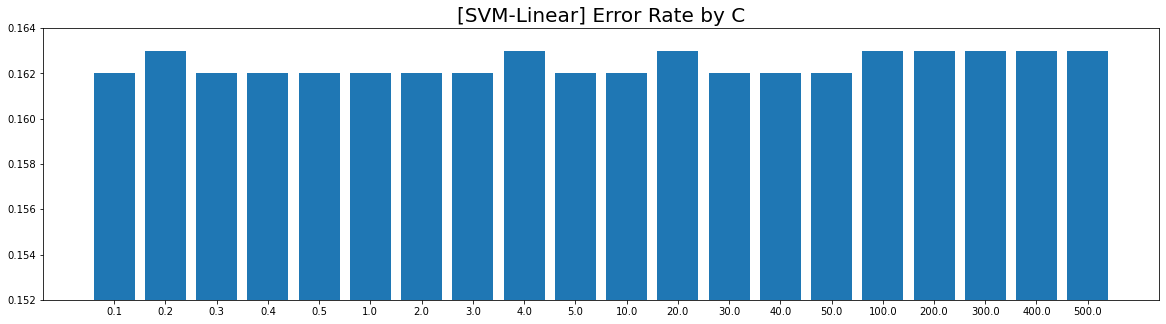

In [13]:
SVM_linear_result_viz = dict(sorted(SVM_linear_result.items()))
plt.figure(figsize=(20,5))
val = 1-np.array(list(SVM_linear_result_viz.values()))
plt.bar(range(len(SVM_linear_result_viz)), val, align='center')
plt.xticks(range(len(SVM_linear_result_viz)), [np.round(i,3) for i in list(SVM_linear_result_viz.keys())])
plt.ylim(min(val)-0.01, max(val)+0.001)
plt.title('[SVM-Linear] Error Rate by C', size=20)
plt.show()

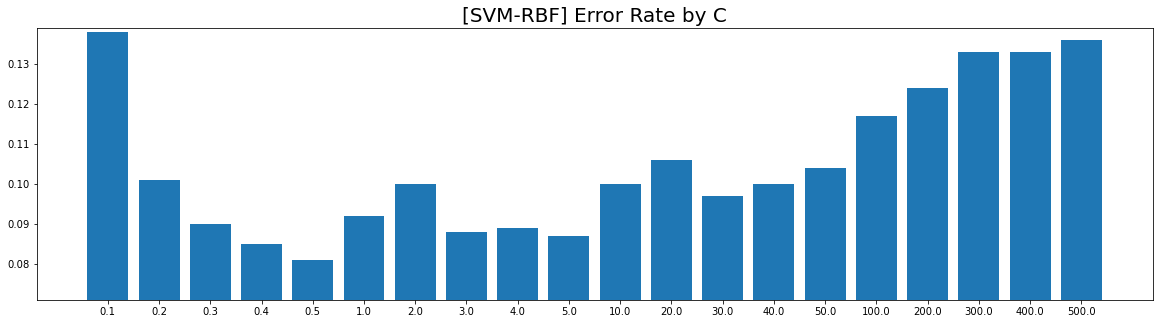

In [14]:
SVM_rbf_result_viz = dict(sorted(SVM_rbf_result.items()))
plt.figure(figsize=(20,5))
val = 1-np.array(list(SVM_rbf_result_viz.values()))
plt.bar(range(len(SVM_rbf_result_viz)), val, align='center')
plt.xticks(range(len(SVM_rbf_result_viz)), [np.round(i,3) for i in list(SVM_rbf_result_viz.keys())])
plt.ylim(min(val)-0.01, max(val)+0.001)
plt.title('[SVM-RBF] Error Rate by C', size=20)
plt.show()

In [15]:
text = f'''Linear Kernel SVM (C={best_C_linear})

Confusion Matrix (SVM-linear)
-----------------------------
{confusion_matrix(y_ts, best_y_ts_pred_linear)}

Model Summary (SVM-linear)
--------------------------
overall accuracy = {np.mean(best_y_ts_pred_linear == y_ts):.3f}


RBF Kernel SVM (C={best_C_rbf})

Confusion Matrix (SVM-rbf)
--------------------------
{confusion_matrix(y_ts, best_y_ts_pred_rbf)}

Model Summary (SVM-rbf)
-----------------------
overall accuracy = {np.mean(best_y_ts_pred_rbf == y_ts):.3f}
'''

In [16]:
file = open(out_name, "w") 
file.write(text)
file.close()